* EDA (Eploratory Data Analysis)

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit

In [5]:
data_path = '../data/input/demand-forecasting-kernels-only/'

train_df = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates=['date'])
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'), parse_dates=['date'])
submission_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))

# parse_date = [] converts the strings its find there into real datetime64[ns]

In [6]:
print("train Shape:", train_df.shape)
print("Tese Shape:", test_df.shape)
print("Sample Submission Shape:", submission_df.shape)

train Shape: (913000, 4)
Tese Shape: (45000, 4)
Sample Submission Shape: (45000, 2)


In [7]:
print("\nTrain Head:")
print(train_df.head)
print("\nTest Head:")
print(test_df.head())


Train Head:
<bound method NDFrame.head of              date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]>

Test Head:
   id       date  store  item
0   0 2018-01-01      1     1
1   1 2018-01-02      1     1
2   2 2018-01-03      1     1
3   3 2018-01-04      1     1
4   4 2018-01-05      1     1


* Basic Data Inspection:

1. Checking data types, missing values, and uniques values
2. Understanding the date range

In [8]:
print("\nTrain Info:")
train_df.info()
print("\nTest Info:")
test_df.info()


Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB

Test Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      45000 non-null  int64         
 1   date    45000 non-null  datetime64[ns]
 2   store   45000 non-null  int64         
 3   item    45000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.4 MB


In [10]:
print("\Missing Values in Train:")
print(train_df.isnull().sum())
print("\nMissing Values in Test:")
print(test_df.isnull().sum())

# There are no NaN values.

\Missing Values in Train:
date     0
store    0
item     0
sales    0
dtype: int64

Missing Values in Test:
id       0
date     0
store    0
item     0
dtype: int64


<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Parsan Afzar\AppData\Local\Temp\ipykernel_13200\2204220683.py:1: SyntaxWarning: invalid escape sequence '\M'
  print("\Missing Values in Train:")


In [13]:
print("Training Date Range: {} to {}".format(train_df['date'].min(), train_df['date'].max()))
print("\nTest Date Range: {} to {}".format(test_df['date'].min(), test_df['date'].max()))

# Train Data : 5 years and 1 day
# Test Data: 90 days

Training Date Range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00

Test Date Range: 2018-01-01 00:00:00 to 2018-03-31 00:00:00


In [20]:
print("\nUnique Stores (Train_df): ", train_df['store'].nunique())
print("\nUnique Items (Train-df): ", train_df['item'].nunique())
print("\nUnique Stores (Tese_df): ", test_df['store'].unique())
print("\nUnique Items (Test_df): ",test_df['item'].nunique())

# Cause im not seeing any NaN values and our date is no datetime type and store and item are integers.
# I'll move on to the next step and more analysis maybe.


Unique Stores (Train_df):  10

Unique Items (Train-df):  50

Unique Stores (Tese_df):  [ 1  2  3  4  5  6  7  8  9 10]

Unique Items (Test_df):  50


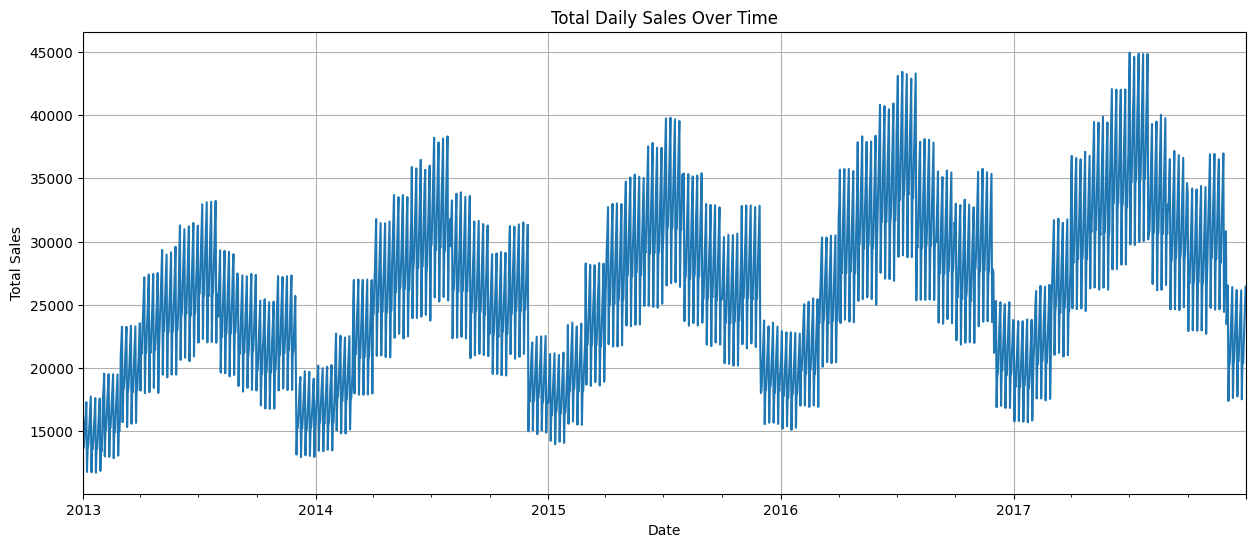

In [18]:
# Fining out the overall sales trends:

# Having date as index so that we can do time series plotting easier

train_df_indexed = train_df.set_index('date').sort_index() # Moving one column more into the index and setting the order ascending

plt.figure(figsize=(15, 6))
train_df_indexed['sales'].resample('D').sum().plot(title='Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.savefig('../data/output/Total_daily_sales_over_time.png')
plt.show()

# This simple line chart shows a near 3x increase in five years.

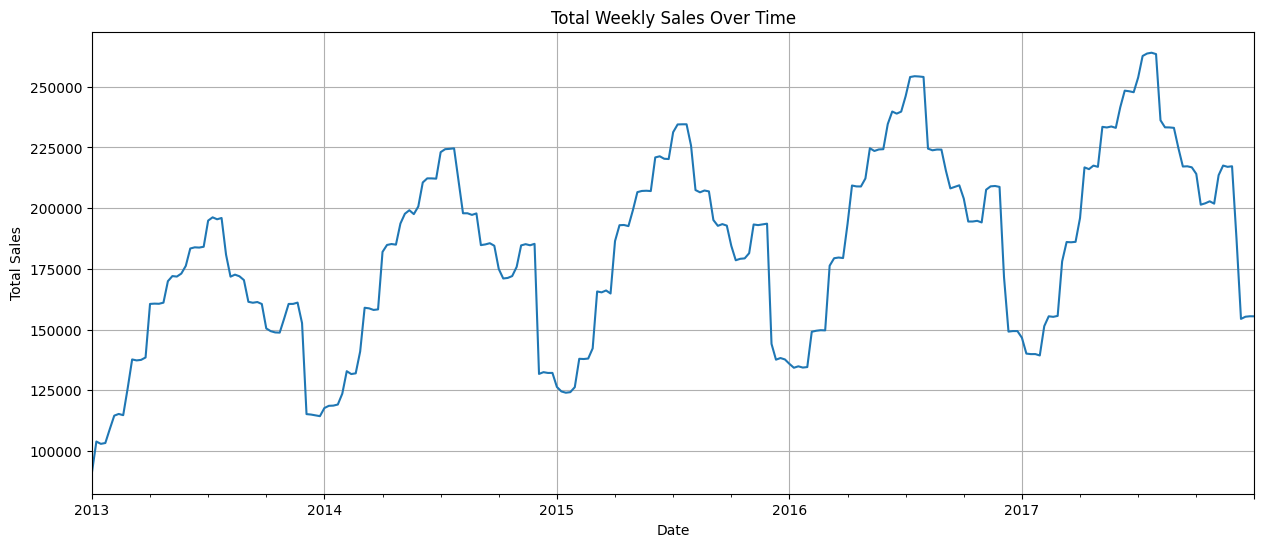

In [22]:
plt.figure(figsize=(15, 6))
train_df_indexed['sales'].resample('W').sum().plot(title='Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.savefig('../data/output/total_weekly_sales_over_time.png')
plt.show()

# This line is smooth and nearly linear

C:\Users\Parsan Afzar\AppData\Local\Temp\ipykernel_13200\2770128513.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = train_df_indexed['sales'].resample('Y').sum()


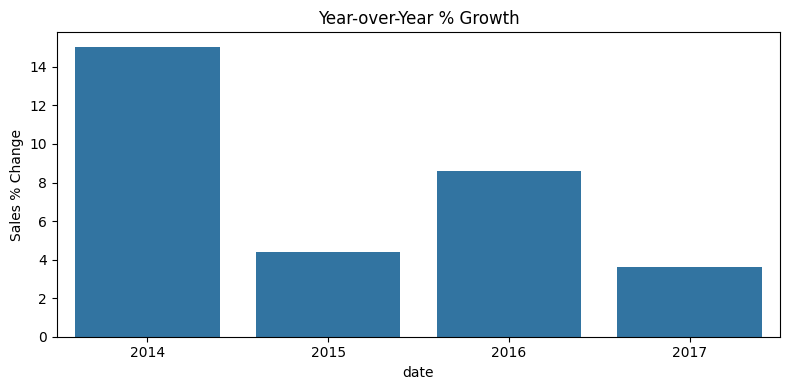

In [23]:
yearly = train_df_indexed['sales'].resample('Y').sum()
year_over_year = yearly.pct_change()*100
plt.figure(figsize=(8, 4))
sns.barplot(x=year_over_year.index.year[1:], y=year_over_year.values[1:])
plt.title('Year-over-Year % Growth')
plt.ylabel('Sales % Change')
plt.tight_layout()
plt.savefig('../data/output/year_over_year_growth.png')
plt.show()

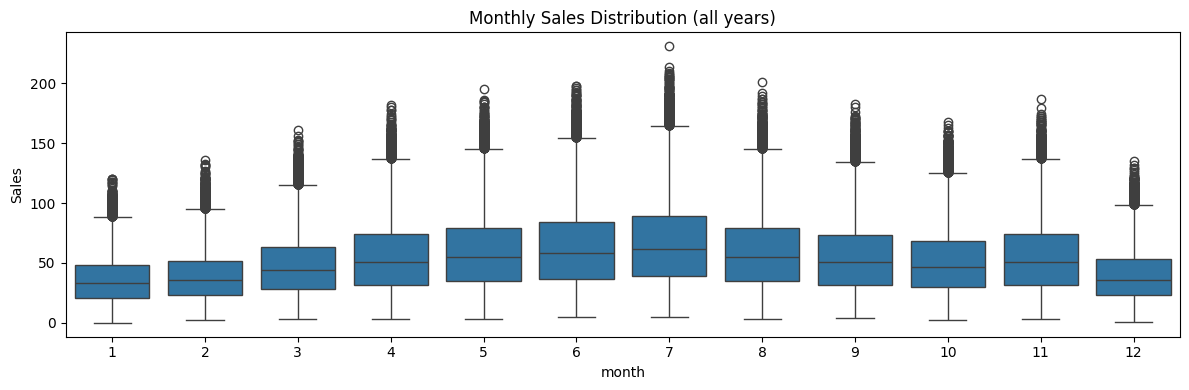

In [ ]:
train_df_indexed['month'] = train_df_indexed.index.month
plt.figure(figsize=(12,4))
sns.boxplot(x='month', y='sales', data=train_df_indexed)
plt.title('Monthly Sales Distribution (all years)')
plt.ylabel('Sales')
plt.tight_layout()
plt.savefig('../data/output/monthly_boxplot.png')
plt.show()

# median sales peak in summer (7-8) and a drop in winter (12)
# Dec(12) we have the lowest median
# There are dots above the whiskers but cluster above July(6) and August(7) whcih shows a demand spike

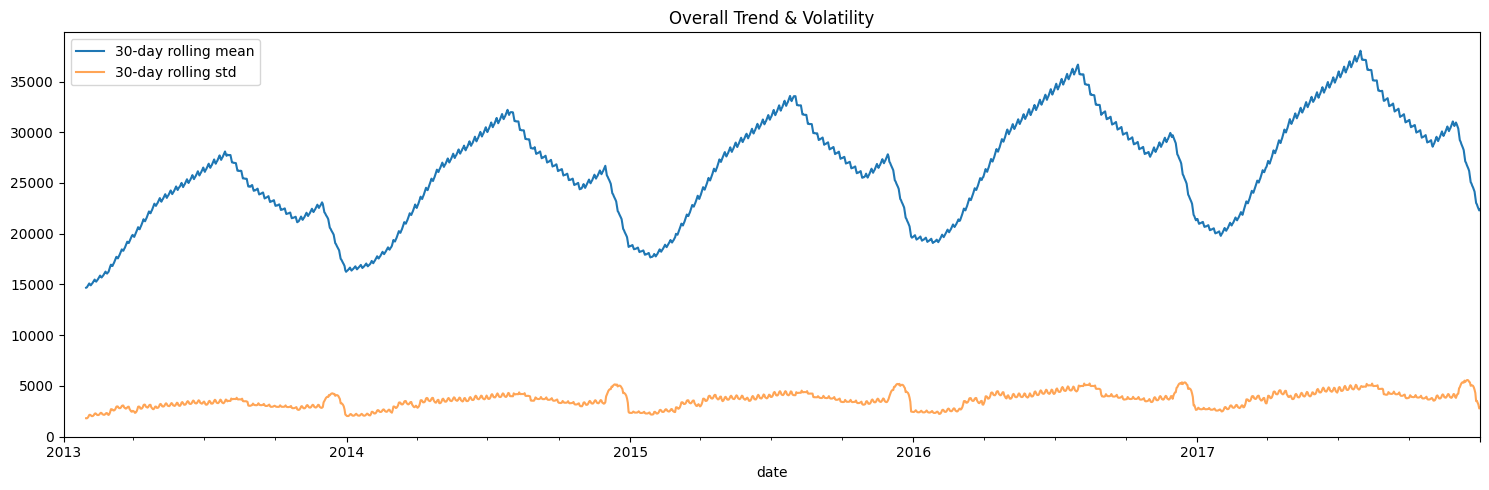

In [29]:
daily = train_df_indexed['sales'].resample('D').sum()
rolling = daily.rolling(window=30).agg(['mean','std'])
plt.figure(figsize=(15,5))
rolling['mean'].plot(label='30-day rolling mean')
rolling['std'].plot(label='30-day rolling std', alpha=0.7)
plt.title('Overall Trend & Volatility')
plt.legend()
plt.tight_layout()
plt.savefig('../data/output/rolling_trend.png')
plt.show()

# Trend (blue) – 30-day rolling mean climbs steadily from ~15 k (2013) to ≈35 k (2017) – a 2.3× growth with no major reversals.
# Volatility (orange) – 30-day rolling standard deviation tracks the same upward path, telling us bigger swings appear as the absolute level rises; peaks around ±5 k by 2017.
# the mean/std ratio stays roughly constant, so relative volatility is stable—the series is purely multiplicative (good to log-transform before modelling)

In [32]:
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day_of_week'] = train_df['date'].dt.dayofweek # Monday=0, Sunday=6
train_df['day_of_year'] = train_df['date'].dt.dayofyear
train_df['week_of_year'] = train_df['date'].dt.isocalendar().week.astype(int)

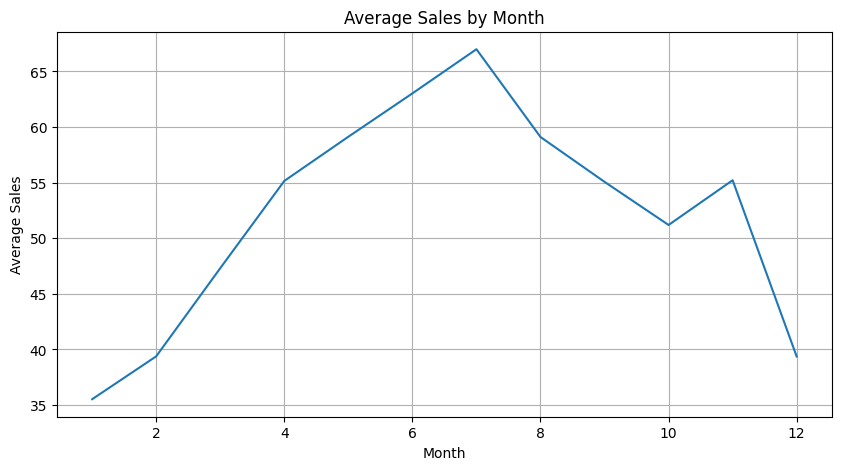

In [34]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=train_df.groupby('month')['sales'].mean().reset_index(), x='month', y='sales')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.grid(True)
plt.savefig('../data/output/average_sales_by_month.png')
plt.show()

# The line chart shows average sales by month, peaking in July (month 7) and dipping to the lowest in January (month 1) and December (month 12). 

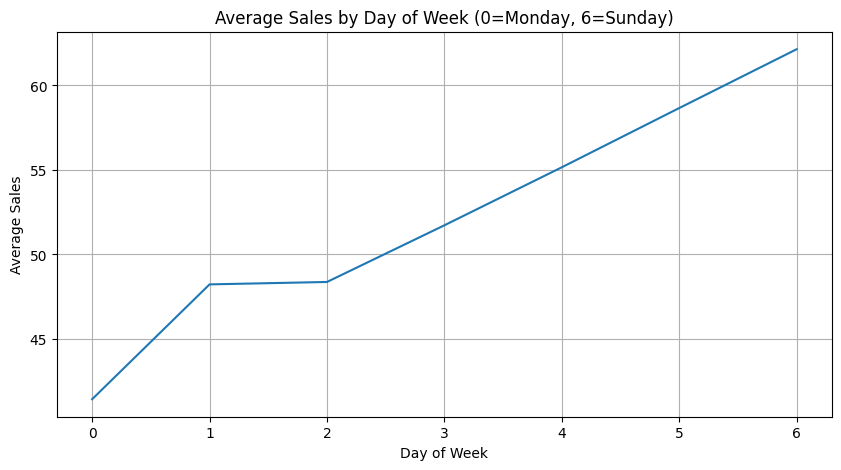

In [36]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=train_df.groupby('day_of_week')['sales'].mean().reset_index(), x='day_of_week', y='sales')
plt.title('Average Sales by Day of Week (0=Monday, 6=Sunday)')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.grid(True)
plt.savefig('../data/output/average_sales_by_day.png')
plt.show()

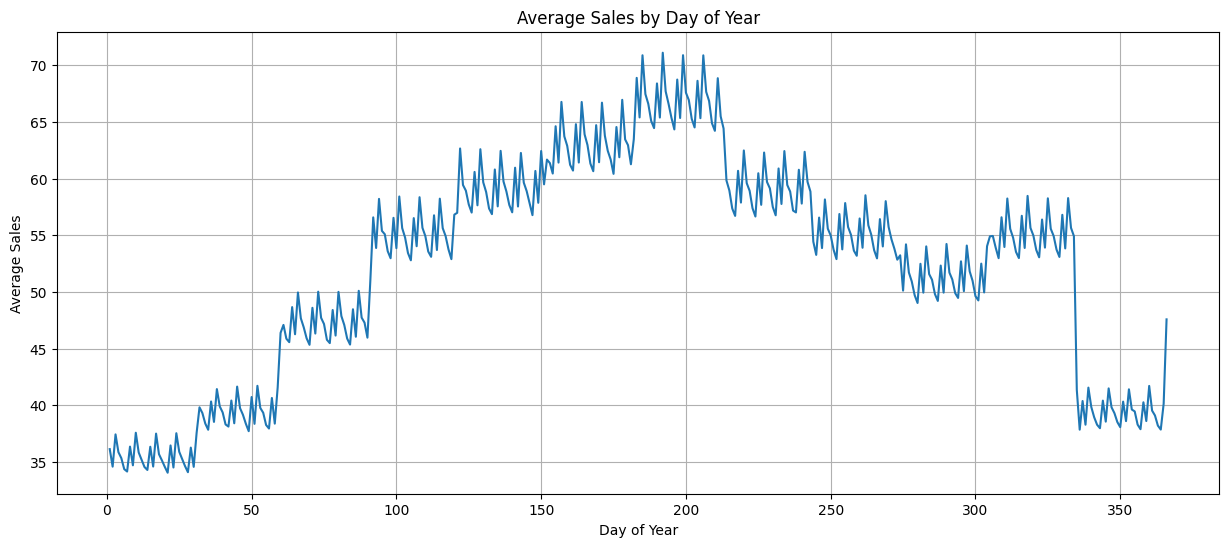

In [39]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=train_df.groupby('day_of_year')['sales'].mean().reset_index(), x='day_of_year', y='sales')
plt.title('Average Sales by Day of Year')
plt.xlabel('Day of Year')
plt.ylabel('Average Sales')
plt.grid(True)
plt.savefig('../data/output/average_sales_by_week.png')
plt.show()

#A gradual increase from the start of the year, with sales peaking around mid-year (roughly day 180–210).
#A weekly oscillation pattern is visible, indicating recurring short-term fluctuations.
#After the peak, sales decline gradually, with a sharp drop near the end of the year (around day 330).
#There's a slight recovery right at the year's end.

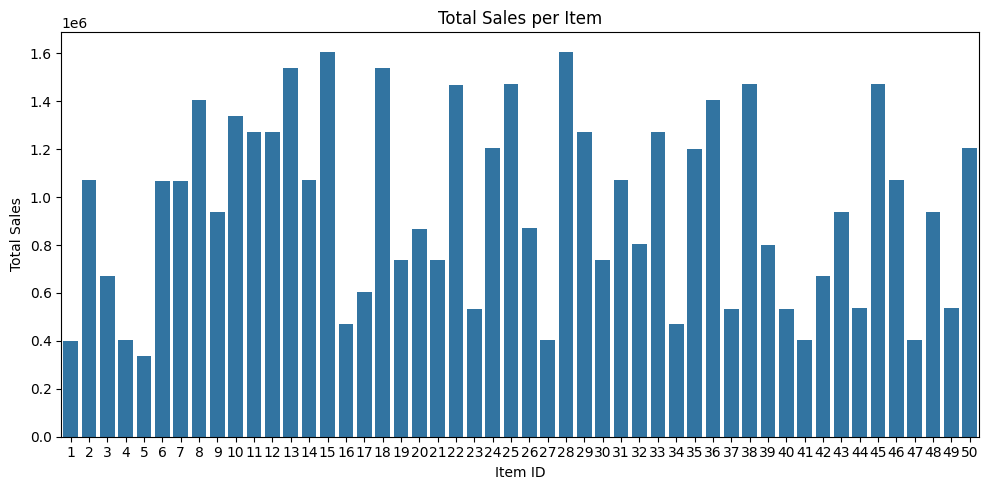

In [45]:
plt.figure(figsize=(10, 5))
sns.barplot(x=train_df.groupby('item')['sales'].sum().index, y=train_df.groupby('item')['sales'].sum().values)
plt.title('Total Sales per Item')
plt.xlabel('Item ID')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.savefig('../data/output/total_sales_per_item.png')
plt.show()

# Item 14 and 28 are top ones near 1.6 million each
# Item 4 and 33 are much lower near 0.4 million each.

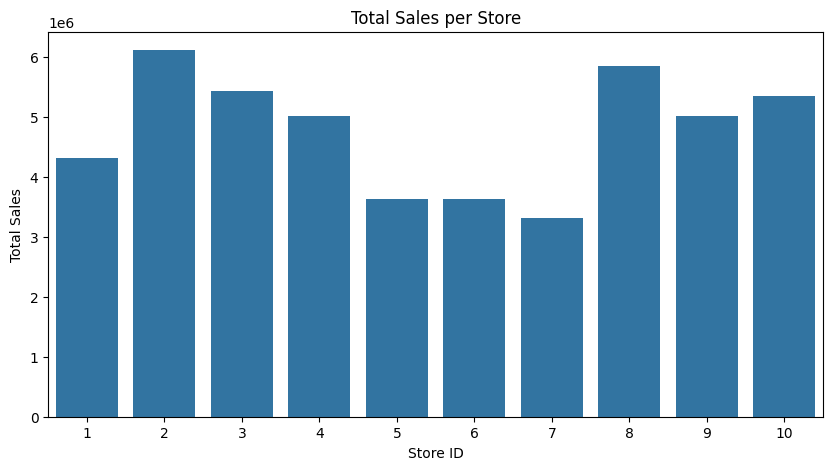

In [49]:
plt.figure(figsize=(10, 5))
sns.barplot(x=train_df.groupby('store')['sales'].sum().index, y=train_df.groupby('store')['sales'].sum().values)
plt.title('Total Sales per Store')
plt.xlabel('Store ID')
plt.ylabel('Total Sales')
plt.savefig('../data/output/total_sales_per_store.png')
plt.show()
# Store 2 is the highest one around 6.2 million
# Store 8 is the second one around 5.9 milion
# Store 7 is the lowest one around 3.3 million

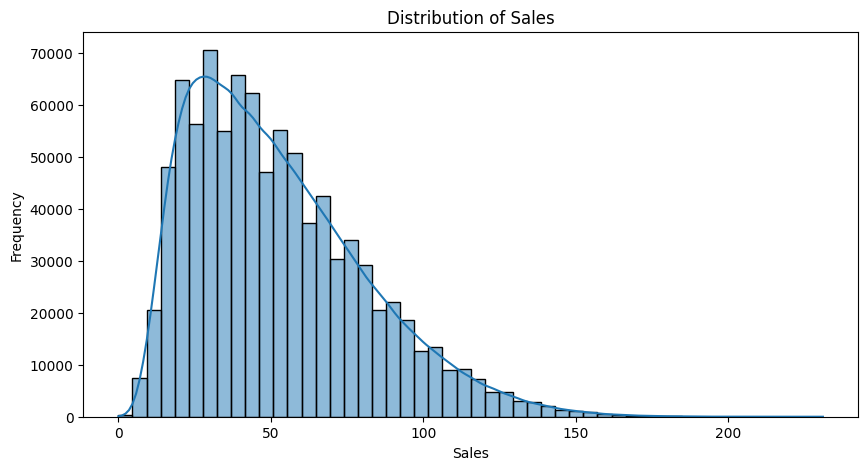

Number of zero sales: 1


In [52]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df['sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.savefig('../data/output/distribution_of_sales.png')
plt.show()

print(f"Number of zero sales: {(train_df['sales'] == 0).sum()}")

# A sale value of 30 to 4o$ shows the most frequent amount(over 7000 times)
# A right skewed distribution
# most sales are for smaller amounts, while high-value sales are much less common

What we learned in one breath:

Sales rose 3× in 5 years, always jump in summer/June-July, dip in winter, peak Sundays, slump Mondays. Store and item matter a lot, and because bigger sales bring bigger swings we’ll just log them. 

* Feature Engineering

In [53]:
def create_time_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype(int) # 1 if weekend, 0 otherwise
    return df

In [56]:
train_df = create_time_features(train_df)
test_df = create_time_features(test_df)

print("Time features created for train and test sets.")
train_df.head()
# now we have a cleaner and more analyzable table

Time features created for train and test sets.


,date,store,item,sales,year,month,day_of_week,day_of_year,week_of_year,quarter,is_weekend
0,2013-01-01,1,1,13,2013,1,1,1,1,1,0
1,2013-01-02,1,1,11,2013,1,2,2,1,1,0
2,2013-01-03,1,1,14,2013,1,3,3,1,1,0
3,2013-01-04,1,1,13,2013,1,4,4,1,1,0
4,2013-01-05,1,1,10,2013,1,5,5,1,1,1


In [57]:
# Lag features are past values of a time series. 
# For this problem, knowing the sales for an item in 
# a specific store 90 days ago or a year ago is highly predictive of the sales today. 
# We will create lags that correspond to the 90-day test period and yearly seasonality.

combined_df = pd.concat([train_df, test_df], sort=False, ignore_index=True) #This ensures that we can calculate lags for the start of the test set using values from the end of the train set.

# Sort by store, item, and date to ensure correct sequential order
combined_df.sort_values(by=['store', 'item', 'date'], inplace=True)

In [60]:
lag_periods = [90, 91, 98, 180, 364, 365]

for lag in lag_periods:
    combined_df[f'sales_lag_{lag}'] = combined_df.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(lag))

combined_df[combined_df['item']==1].tail()
# Lag: Using past data to predict the future.

,date,store,item,sales,year,month,day_of_week,day_of_year,week_of_year,quarter,is_weekend,id,sales_lag_90,sales_lag_91,sales_lag_98,sales_lag_180,sales_lag_364,sales_lag_365
913895,2018-03-27,10,1,NaN,2018,3,1,86,13,1,0,895.0,19.0,16.0,18.0,19.0,26.0,11.0
913896,2018-03-28,10,1,NaN,2018,3,2,87,13,1,0,896.0,12.0,19.0,23.0,22.0,20.0,26.0
913897,2018-03-29,10,1,NaN,2018,3,3,88,13,1,0,897.0,23.0,12.0,12.0,32.0,24.0,20.0
913898,2018-03-30,10,1,NaN,2018,3,4,89,13,1,0,898.0,26.0,23.0,24.0,34.0,31.0,24.0
913899,2018-03-31,10,1,NaN,2018,3,5,90,13,1,1,899.0,27.0,26.0,19.0,17.0,27.0,31.0


In [63]:
rolling_windows = [7, 14, 28, 90]
shift_period = 90

for window in rolling_windows:
    combined_df[f'sales_rolling_mean_{window}'] = combined_df.groupby(['store', 'item'])['sales'].transform(
        lambda x: x.shift(shift_period).rolling(window).mean()
    )
    combined_df[f'sales_rolling_std_{window}'] = combined_df.groupby(['store', 'item'])['sales'].transform(
        lambda x: x.shift(shift_period).rolling(window).std()
    )

# Rolling-window features = summary stats (mean, std, min, max, …) calculated over the last 90 observations as the window “rolls” through time.
# They capture recent trend & volatility without looking into the future.

In [ ]:
print("Number of NaN sales before split:", combined_df['sales'].isna().sum())

Number of NaN sales before split: 45000


In [80]:
print(f"Shape of combined_df before split: {combined_df.shape}")
print(f"Number of NaN sales in combined_df: {combined_df['sales'].isna().sum()}")

Shape of combined_df before split: (958000, 26)
Number of NaN sales in combined_df: 45000


In [84]:
# Spliting the data using .copy() to be safe
train_final_df = combined_df[combined_df['sales'].notna()].copy()
test_final_df = combined_df[combined_df['sales'].isna()].copy()

print("Shape of train_final_df immediately after split:", train_final_df.shape)
print("Shape of test_final_df immediately after split:", test_final_df.shape)

Shape of train_final_df immediately after split: (913000, 26)
Shape of test_final_df immediately after split: (45000, 26)


In [85]:
# Filling NaN values created by feature engineering
train_final_df.fillna(-1, inplace=True)
test_final_df.fillna(-1, inplace=True)

print("Shape of train_final_df after filling NaNs:", train_final_df.shape)

Shape of train_final_df after filling NaNs: (913000, 26)


In [87]:
# The 'sales' column in test_final_df is all -1 now
if 'sales' in test_final_df.columns:
    test_final_df.drop('sales', axis=1, inplace=True)

print("Final Train Shape:", train_final_df.shape)
print("Final Test Shape:", test_final_df.shape)

Final Train Shape: (913000, 26)
Final Test Shape: (45000, 25)


 Encoding

In [88]:
# Features to apply target encoding to
target_encode_features = ['store', 'item', 'month', 'day_of_week', 'is_weekend', 'quarter']

# Calculate global mean sales to fill any potential missing values in the test set
global_mean_sales = train_final_df['sales'].mean()
print(f"Global mean sales: {global_mean_sales:.2f}")

Global mean sales: 52.25


In [89]:
for feature in target_encode_features:
    # Calculate the mean sales for each category in the training set
    mean_map = train_final_df.groupby(feature)['sales'].mean()
    
    # Create the new feature name
    new_feature_name = f'{feature}_target_enc'
    
    # Map the mean values to the training and test sets
    train_final_df[new_feature_name] = train_final_df[feature].map(mean_map)
    test_final_df[new_feature_name] = test_final_df[feature].map(mean_map)
    
    # Fill any potential NaN values in the test set with the global mean
    # This happens if a category exists in test but not in train
    test_final_df[new_feature_name].fillna(global_mean_sales, inplace=True)

C:\Users\Parsan Afzar\AppData\Local\Temp\ipykernel_13200\1344926569.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_final_df[new_feature_name].fillna(global_mean_sales, inplace=True)
C:\Users\Parsan Afzar\AppData\Local\Temp\ipykernel_13200\1344926569.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

In [91]:
print("\nTarget encoding complete. New features added.")
print("Train set with new features:")
print(train_final_df[['date', 'store', 'item', 'sales', 'store_target_enc', 'item_target_enc']].head())

print("\nTest set with new features:")
print(test_final_df[['date', 'store', 'item', 'id', 'store_target_enc', 'item_target_enc']].head())


Target encoding complete. New features added.
Train set with new features:
        date  store  item  sales  store_target_enc  item_target_enc
0 2013-01-01      1     1   13.0         47.268379        21.981599
1 2013-01-02      1     1   11.0         47.268379        21.981599
2 2013-01-03      1     1   14.0         47.268379        21.981599
3 2013-01-04      1     1   13.0         47.268379        21.981599
4 2013-01-05      1     1   10.0         47.268379        21.981599

Test set with new features:
             date  store  item   id  store_target_enc  item_target_enc
913000 2018-01-01      1     1  0.0         47.268379        21.981599
913001 2018-01-02      1     1  1.0         47.268379        21.981599
913002 2018-01-03      1     1  2.0         47.268379        21.981599
913003 2018-01-04      1     1  3.0         47.268379        21.981599
913004 2018-01-05      1     1  4.0         47.268379        21.981599


In [92]:
print("\nFinal shapes after target encoding:")
print("Final Train Shape:", train_final_df.shape)
print("Final Test Shape:", test_final_df.shape)


Final shapes after target encoding:
Final Train Shape: (913000, 32)
Final Test Shape: (45000, 31)


In [93]:
# Categorical Feature Encoding
print("Data types of key categorical columns:")
print(train_final_df[['store', 'item']].dtypes)

Data types of key categorical columns:
store    int64
item     int64
dtype: object


In [94]:
# Harmonic Features for Seasonality
def create_harmonic_features(df):
    # For yearly seasonality
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    
    # For weekly seasonality
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # For monthly seasonality
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

train_final_df = create_harmonic_features(train_final_df)
test_final_df = create_harmonic_features(test_final_df)

print("Harmonic features created for both train and test sets.")
print(train_final_df[['date', 'day_of_week', 'day_of_week_sin', 'day_of_week_cos']].head())

Harmonic features created for both train and test sets.
        date  day_of_week  day_of_week_sin  day_of_week_cos
0 2013-01-01            1         0.781831         0.623490
1 2013-01-02            2         0.974928        -0.222521
2 2013-01-03            3         0.433884        -0.900969
3 2013-01-04            4        -0.433884        -0.900969
4 2013-01-05            5        -0.974928        -0.222521


In [95]:
# Final Data Preparation & Cleanup
print(f"Shape of train_final_df before dropping NaNs: {train_final_df.shape}")
initial_rows = train_final_df.shape[0]
train_final_df.dropna(inplace=True)
final_rows = train_final_df.shape[0]

print(f"Dropped {initial_rows - final_rows} rows from the training set.")
print(f"Shape of train_final_df after dropping NaNs: {train_final_df.shape}")

Shape of train_final_df before dropping NaNs: (913000, 38)
Dropped 0 rows from the training set.
Shape of train_final_df after dropping NaNs: (913000, 38)


In [96]:
print(f"Any NaNs in final training data: {train_final_df.isnull().sum().sum()}")
print(f"Any NaNs in final test data: {test_final_df.isnull().sum().sum()}")

print("\nFinal Model-Ready Shapes:")
print(f"Train: {train_final_df.shape}")
print(f"Test:  {test_final_df.shape}")

Any NaNs in final training data: 0
Any NaNs in final test data: 0

Final Model-Ready Shapes:
Train: (913000, 38)
Test:  (45000, 37)


* Model

In [98]:
# Create a validation set from the last 90 days of the training data
max_date = train_final_df['date'].max()
split_date = max_date - pd.DateOffset(days=89)

val_df = train_final_df[train_final_df['date'] >= split_date].copy()
train_part_df = train_final_df[train_final_df['date'] < split_date].copy()

print(f"Training data from {train_part_df['date'].min().date()} to {train_part_df['date'].max().date()}")
print(f"Validation data from {val_df['date'].min().date()} to {val_df['date'].max().date()}")
print(f"Train part shape: {train_part_df.shape}")
print(f"Validation part shape: {val_df.shape}")

Training data from 2013-01-01 to 2017-10-02
Validation data from 2017-10-03 to 2017-12-31
Train part shape: (868000, 38)
Validation part shape: (45000, 38)


In [100]:
# Evaluation Metric: SMAPE (Symmetric Mean Absolute Percentage Error)

def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio) * 100

print("SMAPE function defined.")

SMAPE function defined.


In [101]:
# Baseline 1: Last Observed Value (90-Day Lag)

# This model predicts that the sales for a given day will be the same as the sales from 90 days ago for that same store-item combination. We already created the `sales_lag_90` feature for this.

y_true_val = val_df['sales']
y_pred_lag90 = val_df['sales_lag_90']

smape_lag90 = smape(y_true_val, y_pred_lag90)

print(f"SMAPE for 90-Day Lag Baseline: {smape_lag90:.4f}")

SMAPE for 90-Day Lag Baseline: 29.9530


In [106]:
# Baseline 2: Simple Average per Store-Item
# This model predicts that the sales for a given store-item combination will be its historical average, calculated from the training portion of the data.

# Calculate average sales for each store-item group using the training part
store_item_avg = train_part_df.groupby(['store', 'item'])['sales'].mean().reset_index()
store_item_avg.rename(columns={'sales': 'avg_sales'}, inplace=True)

# Merge this average onto the validation set
val_merged = pd.merge(val_df, store_item_avg, on=['store', 'item'], how='left')

# Fallback for any new store-item pairs (unlikely with this split, but good practice)
global_avg = train_part_df['sales'].mean()
val_merged['avg_sales'].fillna(global_avg, inplace=True)

# Calculate SMAPE
y_true_val = val_merged['sales'] 
y_pred_avg = val_merged['avg_sales']

smape_avg = smape(y_true_val, y_pred_avg)

print(f"SMAPE for Simple Average Baseline: {smape_avg:.4f}")
# our predictions will be wrong by about 19.8% on average.

SMAPE for Simple Average Baseline: 19.7589


C:\Users\Parsan Afzar\AppData\Local\Temp\ipykernel_13200\1449354819.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  val_merged['avg_sales'].fillna(global_avg, inplace=True)


In [108]:
# Model Training and Evaluation
# We will now train and evaluate several models in a structured loop. This allows us to compare their performance on our validation set and select the best one for the final prediction.

# Additional imports for this section
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

# 1. Define Features (X) and Target (y) for validation
features = [col for col in train_final_df.columns if col not in ['date', 'id', 'sales']]
categorical_features = ['store', 'item', 'day_of_week', 'month', 'year', 'is_weekend', 'quarter']

X_train = train_part_df[features]
y_train = train_part_df['sales']
X_val = val_df[features]
y_val = val_df['sales']

# For the final model submission
X_test = test_final_df[features]

print(f"Training with {len(features)} features.")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

# 2. Define Models to Train
# We define our models in a dictionary for easy iteration.
models = {
    "LightGBM": lgb.LGBMRegressor(random_state=42, objective='regression_l1', metric='mae', n_jobs=-1, verbose=-1),
    "XGBoost": xgb.XGBRegressor(random_state=42, objective='reg:squarederror', eval_metric='mae', n_jobs=-1),
    "Ridge": Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))
    ])
}

# Dictionary to store results
results = {}

# 3. Training and Evaluation Loop
for name, model in models.items():
    print(f"--- Training {name} ---")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred_val = model.predict(X_val)
    
    # Ensure predictions are non-negative
    y_pred_val[y_pred_val < 0] = 0
    
    # Calculate SMAPE score
    score = smape(y_val, y_pred_val)
    results[name] = score
    
    print(f"SMAPE for {name}: {score:.4f}\n")

# 4. Compare Results and Select Best Model
print("--- Model Comparison ---")
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['SMAPE_Score']).sort_values(by='SMAPE_Score')
print(results_df)

best_model_name = results_df.index[0]
best_model = models[best_model_name]
print(f"\nBest performing model: {best_model_name} with SMAPE: {results_df.iloc[0,0]:.4f}")

# 5. Create Submission File with the Best Model
# Retrain the best model on the full training data
print(f"\nRetraining best model ({best_model_name}) on full training data...")
X_full_train = train_final_df[features]
y_full_train = train_final_df['sales']

best_model.fit(X_full_train, y_full_train)

print("Predicting on test data...")
predictions = best_model.predict(X_test)

# Ensure predictions are non-negative
predictions[predictions < 0] = 0

# Create the submission DataFrame
submission_df = pd.DataFrame({'id': test_final_df['id'], 'sales': predictions})

# Save to csv
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.csv' created successfully with the best model.")
print(submission_df.head())

Training with 35 features.
X_train shape: (868000, 35)
X_val shape: (45000, 35)
X_test shape: (45000, 35)
--- Training LightGBM ---
SMAPE for LightGBM: 12.9354

--- Training XGBoost ---
SMAPE for XGBoost: 12.6444

--- Training Ridge ---
SMAPE for Ridge: 17.6092

--- Model Comparison ---
          SMAPE_Score
XGBoost     12.644409
LightGBM    12.935363
Ridge       17.609183

Best performing model: XGBoost with SMAPE: 12.6444

Retraining best model (XGBoost) on full training data...
Predicting on test data...

Submission file 'submission.csv' created successfully with the best model.
         id      sales
913000  0.0  13.318505
913001  1.0  13.812431
913002  2.0  15.080324
913003  3.0  15.300903
913004  4.0  17.989820


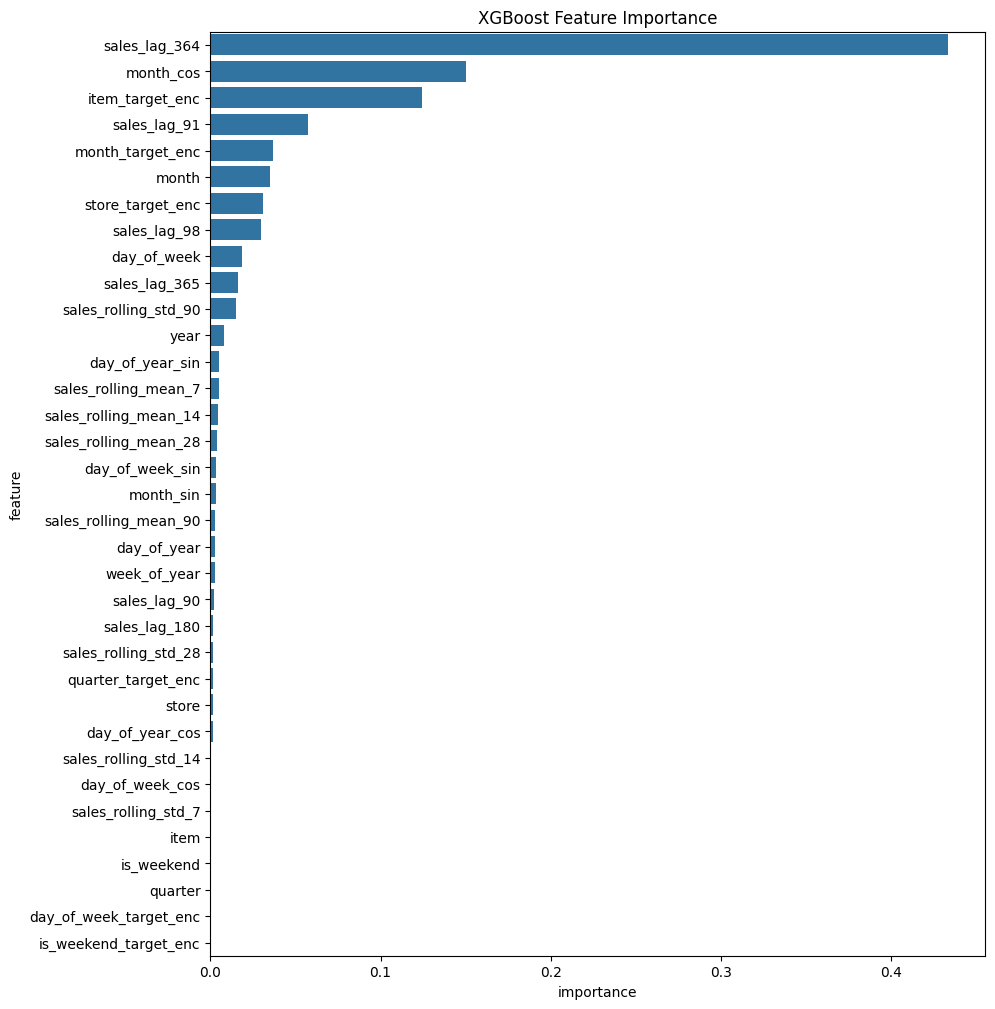

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.DataFrame({
    'feature': X_full_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('XGBoost Feature Importance')
plt.show()

# Past Sales are the most critical predictors.
# Monthly/Yearly Seasonality (month_cos, month_target_enc) and Item/Store Averages (item_target_enc, store_target_enc) are also highly influential.

In [111]:
# Managerial Report: 30-Day Demand Forecast
# This section translates the model's daily predictions into an actionable purchasing plan for the next 30 days.

# 1. Combine predictions with test set details
report_df = pd.merge(test_df[['id', 'date', 'store', 'item']], submission_df, on='id')

# 2. Define the 30-day forecast horizon
start_date = report_df['date'].min()
end_date = start_date + pd.DateOffset(days=29)
print(f"Generating report for forecast horizon: {start_date.date()} to {end_date.date()}")

# 3. Filter for the 30-day horizon
thirty_day_forecast = report_df[(report_df['date'] >= start_date) & (report_df['date'] <= end_date)]

# 4. Aggregate total demand per item
# We sum the predicted sales across all stores for each item
item_demand_30_days = thirty_day_forecast.groupby('item')['sales'].sum().reset_index()
item_demand_30_days.rename(columns={'sales': 'predicted_demand_30_days'}, inplace=True)

# 5. Sort to find top-demand items
top_items_to_purchase = item_demand_30_days.sort_values(by='predicted_demand_30_days', ascending=False)

# Round the demand for cleaner presentation
top_items_to_purchase['predicted_demand_30_days'] = top_items_to_purchase['predicted_demand_30_days'].round(0).astype(int)

# 6. Display the report
print("\n--- Top Items to Purchase (Next 30 Days) ---")
print("This table shows the total predicted sales demand for each item across all stores.")
print(top_items_to_purchase.head(15).to_string(index=False))

Generating report for forecast horizon: 2018-01-01 to 2018-01-30

--- Top Items to Purchase (Next 30 Days) ---
This table shows the total predicted sales demand for each item across all stores.
 item  predicted_demand_30_days
   15                     20555
   28                     20551
   13                     19684
   18                     19618
   45                     18886
   38                     18832
   22                     18821
   25                     18716
    8                     17915
   36                     17914
   10                     17141
   11                     16310
   29                     16270
   12                     16236
   33                     16147


In [113]:
# Model Improvement: Hyperparameter Tuning
# We will now tune the best performing model (XGBoost) to see if we can improve its accuracy. We use `RandomizedSearchCV` for efficiency, combined with `TimeSeriesSplit` for correct time-series cross-validation.

# 1. Define the parameter grid for Randomized Search
# This grid contains the range of settings we want to test for XGBoost.
param_grid = {
    'n_estimators': [1000, 1500, 2000],
    'learning_rate': [0.01, 0.02, 0.05],
    'max_depth': [5, 6, 7, 8],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# 2. Set up TimeSeriesSplit for cross-validation
# This ensures that we always train on past data to predict future data.
tscv = TimeSeriesSplit(n_splits=3)

# 3. Initialize RandomizedSearchCV
# We use n_iter to control how many different parameter combinations are tried.
# We use 'neg_root_mean_squared_error' as the scoring metric.
xgb_tuner = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(random_state=42, objective='reg:squarederror', n_jobs=-1),
    param_distributions=param_grid,
    n_iter=10,  # Increase this for more thorough search, e.g., to 25 or 50
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42
)

# 4. Run the tuner on the training data
print("--- Starting Hyperparameter Tuning for XGBoost ---")
# We use the full training data (train_part_df) for tuning
xgb_tuner.fit(X_train, y_train)

print("\n--- Tuning Complete ---")
print("Best parameters found: ", xgb_tuner.best_params_)

# 5. Evaluate the tuned model
best_tuned_model = xgb_tuner.best_estimator_
y_pred_tuned = best_tuned_model.predict(X_val)
y_pred_tuned[y_pred_tuned < 0] = 0
tuned_smape = smape(y_val, y_pred_tuned)

print("\n--- Performance Comparison ---")
print(f"Original XGBoost SMAPE: {results['XGBoost']:.4f}")
print(f"Tuned XGBoost SMAPE:    {tuned_smape:.4f}")

improvement = results['XGBoost'] - tuned_smape
print(f"Improvement: {improvement:.4f} SMAPE points")

--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits

--- Tuning Complete ---
Best parameters found:  {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.02, 'gamma': 0.2, 'colsample_bytree': 0.7}

--- Performance Comparison ---
Original XGBoost SMAPE: 12.6444
Tuned XGBoost SMAPE:    12.3776
Improvement: 0.2668 SMAPE points


In [114]:
# Final Report with Tuned Model
# Now we generate the final submission and managerial report using the improved, tuned model.

# 1. Retrain the tuned model on all available training data
print("\nRetraining best tuned model on full training data...")
best_tuned_model.fit(X_full_train, y_full_train)

# 2. Make final predictions on the test set
print("Predicting on test data with tuned model...")
tuned_predictions = best_tuned_model.predict(X_test)
tuned_predictions[tuned_predictions < 0] = 0

# 3. Create and save the new submission file
tuned_submission_df = pd.DataFrame({'id': test_final_df['id'], 'sales': tuned_predictions})
tuned_submission_df.to_csv('submission_tuned.csv', index=False)
print("\nSubmission file 'submission_tuned.csv' created successfully.")

# 4. Generate the improved managerial report
print("\n--- Improved Managerial Report (Using Tuned Model) ---")
tuned_report_df = pd.merge(test_df[['id', 'date', 'store', 'item']], tuned_submission_df, on='id')
tuned_thirty_day_forecast = tuned_report_df[(tuned_report_df['date'] >= start_date) & (tuned_report_df['date'] <= end_date)]
tuned_item_demand = tuned_thirty_day_forecast.groupby('item')['sales'].sum().reset_index()
tuned_item_demand.rename(columns={'sales': 'predicted_demand_30_days'}, inplace=True)
tuned_top_items = tuned_item_demand.sort_values(by='predicted_demand_30_days', ascending=False)
tuned_top_items['predicted_demand_30_days'] = tuned_top_items['predicted_demand_30_days'].round(0).astype(int)

print("This table shows the updated total predicted sales demand using the tuned model.")
print(tuned_top_items.head(15).to_string(index=False))


Retraining best tuned model on full training data...
Predicting on test data with tuned model...

Submission file 'submission_tuned.csv' created successfully.

--- Improved Managerial Report (Using Tuned Model) ---
This table shows the updated total predicted sales demand using the tuned model.
 item  predicted_demand_30_days
   28                     20703
   15                     20686
   13                     19724
   18                     19682
   38                     18867
   22                     18859
   45                     18842
   25                     18740
    8                     18010
   36                     18009
   10                     17212
   11                     16350
   29                     16304
   12                     16272
   33                     16208
